In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
from IPython.core.display import Markdown
from IPython.core.display_functions import display

import notebooks.utils as da_utils
import src.config as config
from src.config import FeaturesInfo
from src.db.broker import DbBroker
# from src.features.univariate_analysis import UACleaner
from src.features.utils import downcast_nonnumerical_dtypes
from src.utils import initialize_features_info, preprocess_init

In [2]:
%load_ext autoreload
%autoreload 2

## Get dataset and metadata

In [3]:
def get_dataset_from_db() -> pd.DataFrame:
    db_broker = DbBroker()
    df = pd.read_sql(
        db_broker.get_all_listings_statement(),
        db_broker.engine,
        dtype_backend=config.DTYPE_BACKEND,
        index_col=config.INDEX,
    )
    df = df.rename(str, axis="columns")
    db_broker.engine.dispose()
    return df


def get_metadata() -> FeaturesInfo:
    features_info = initialize_features_info()
    return features_info

In [4]:
df = get_dataset_from_db()
features_info = get_metadata()

## Dataset info

In [5]:
print("Entire dataset")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(20 * "-")
df.info()

Entire dataset
Duplicate rows: 0
--------------------
<class 'pandas.core.frame.DataFrame'>
Index: 30788 entries, 9249043 to 23246511
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      30788 non-null  string
 1   short_url                 30788 non-null  string
 2   price                     30788 non-null  string
 3   listing_followers_no      30788 non-null  string
 4   location                  30788 non-null  string
 5   images_no                 30788 non-null  string
 6   safety                    30788 non-null  string
 7   equipment                 30788 non-null  string
 8   other                     30788 non-null  string
 9   description               30788 non-null  string
 10  id_1                      30788 non-null  Int64 
 11  condition                 30788 non-null  string
 12  brand                     30788 non-null  string
 13  model             

## Entire dataset cleaning

### Initial clean

In [6]:
@preprocess_init
def initial_clean_da(
    df: pd.DataFrame, features_info: FeaturesInfo
) -> Tuple[pd.DataFrame, FeaturesInfo]:
    df.columns = df.columns.astype("string")

    # Prefix columns from table general_informations with "gi_"
    # and additional_informations with "ai"
    id_1_col_idx = df.columns.get_loc("id_1")
    id_2_col_idx = df.columns.get_loc("id_2")

    columns_from_gi = df.columns[id_1_col_idx + 1 : id_2_col_idx].values
    columns_from_ai = df.columns[id_2_col_idx + 1 :].values
        
    df.rename(
        columns=dict(zip(columns_from_gi, "gi_" + columns_from_gi)), inplace=True
    )
    df.rename(
        columns=dict(zip(columns_from_ai, "ai_" + columns_from_ai)), inplace=True
    )
    
    # Removing redundant ids
    del df["id_1"], df["id_2"]

    # Removing gi_fixed_price that is poorly scraped
    del df["gi_fixed_price"]

    return df, features_info

In [7]:
df, features_info = initial_clean_da(df=df, features_info=features_info)

### Feature 'name'

In [8]:
@preprocess_init
def cf_name_da(
    df: pd.DataFrame, features_info: FeaturesInfo
) -> Tuple[pd.DataFrame, FeaturesInfo]:
    feature_name = da_utils.get_feature_name()

    print("Display first 5 rows")
    display(df[[feature_name]].head())
    print()

    print("Display counts by frequencies for the first 20 categories")
    display(df[feature_name].value_counts().head(20))
    print()

    sum_irregular_name_rows = (
        df[feature_name].str.contains("ucesc|učešć", case=False).sum()
    )
    print(f"Irregular 'name' rows count: {sum_irregular_name_rows}")
    display(Markdown("This feature will be left for the Multivariate analysis."))

    features_info["other"].append(feature_name)
    return df, features_info

In [9]:
df, features_info = cf_name_da(df=df, features_info=features_info)

Display first 5 rows


,name
id,
9249043,Volvo 940 DIPLOMATA NOV
9650557,"SsangYong Kyron 2,0 XDI4x4RESTAJLING"
9657017,Audi A4 2.5 TDI Quattro CH
9755964,Dacia Sandero 1.0 TCE 90 LAGER
9921885,Zastava 750 presla 38.400



Display counts by frequencies for the first 20 categories


name
Audi A4                 179
Volkswagen Golf 5       123
Audi A6                 119
BMW 320                 115
Volkswagen Polo         114
Volkswagen Passat B6    106
Audi A3                 105
Renault Megane          102
Škoda Octavia           100
Volkswagen Golf 6        98
Volkswagen Golf 7        87
Ford Focus               82
Renault Clio             79
BMW 520                  73
Ford Fiesta              69
Fiat Punto               68
Opel Corsa D             68
Peugeot 308              67
Citroen C5               65
Audi A4 2.0 TDI          64
Name: count, dtype: Int64


Irregular 'name' rows count: 18


This feature will be left for the Multivariate analysis.

### Feature 'short_url'

In [10]:
@preprocess_init
def cf_short_url_da(
    df: pd.DataFrame, features_info: FeaturesInfo
) -> Tuple[pd.DataFrame, FeaturesInfo]:
    feature_name = da_utils.get_feature_name()

    print("Display first 5 rows")
    display(df[[feature_name]].head())
    print()

    features_info["other"].append(feature_name)
    return df, features_info

In [11]:
df, features_info = cf_name_da(df=df, features_info=features_info)

Display first 5 rows


,name
id,
9249043,Volvo 940 DIPLOMATA NOV
9650557,"SsangYong Kyron 2,0 XDI4x4RESTAJLING"
9657017,Audi A4 2.5 TDI Quattro CH
9755964,Dacia Sandero 1.0 TCE 90 LAGER
9921885,Zastava 750 presla 38.400



Display counts by frequencies for the first 20 categories


name
Audi A4                 179
Volkswagen Golf 5       123
Audi A6                 119
BMW 320                 115
Volkswagen Polo         114
Volkswagen Passat B6    106
Audi A3                 105
Renault Megane          102
Škoda Octavia           100
Volkswagen Golf 6        98
Volkswagen Golf 7        87
Ford Focus               82
Renault Clio             79
BMW 520                  73
Ford Fiesta              69
Fiat Punto               68
Opel Corsa D             68
Peugeot 308              67
Citroen C5               65
Audi A4 2.0 TDI          64
Name: count, dtype: Int64


Irregular 'name' rows count: 18


This feature will be left for the Multivariate analysis.

### Feature 'price'

In [12]:
@preprocess_init
def cf_price_da(
    df: pd.DataFrame, features_info: FeaturesInfo
) -> Tuple[pd.DataFrame, FeaturesInfo]:
    feature_name = da_utils.get_feature_name()
    
    print("Display first 5 rows")
    display(df[[feature_name]].head())
    print()

    # Removing . from values
    df[feature_name] = pd.to_numeric(
        df[feature_name].str.slice(stop=-1).str.replace(".", ""), errors="raise"
    )

    print("Display cars where price=1")
    display(df[df[feature_name] == 1])
    display(
        Markdown(
            "These are cars where price='Po dogovoru' on the website, so that means they didn't have a price to begin with and they will be dropped."
        )
    )
    print()

    # Removing cars that had price=1
    df = df[df[feature_name] != 1]

    print("Display cars where price='Po dogovoru'")
    display(df[df[feature_name] == "Po dogovoru"])

    return df, features_info

In [13]:
df, features_info = cf_price_da(df=df, features_info=features_info)

Display first 5 rows


,price
id,
9249043,18.000 €
9650557,4.500 €
9657017,3.300 €
9755964,16.100 €
9921885,12.999 €



Display cars where price=1


,name,short_url,price,listing_followers_no,location,images_no,safety,equipment,other,description,...,ai_import_country,ai_sales_method,ai_credit,ai_deposit,ai_installment_no,ai_installment_amount,ai_interest_free_credit,ai_leasing,ai_cash_payment,ai_range_on_full_battery_km
id,,,,,,,,,,,,,,,,,,,,,
23220124,Audi A4 RATA 183e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,2,Beograd,39,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Daljinsko zaključavanje,Tonirana s...",,,...,<NA>,<NA>,DA,<NA>,<NA>,183 €,<NA>,<NA>,<NA>,<NA>
23220566,Renault Scenic RATA 148e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,,Beograd,28,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Multifunkcionalni volan,Tempomat,D...",,VOZILO U DOLASKU ...............................,...,<NA>,<NA>,DA,<NA>,<NA>,148 €,<NA>,<NA>,<NA>,<NA>
23221119,Opel Astra J RATA 148e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,1,Beograd,14,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Multifunkcionalni volan,Tempomat,D...",,Vozilo u dolasku ...............................,...,<NA>,<NA>,DA,<NA>,<NA>,148 €,<NA>,<NA>,<NA>,<NA>
23228430,Toyota Yaris RATA 78e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,1,Beograd,17,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Daljinsko zaključavanje,Putni raču...",,VOZILO U DOLASKU,...,<NA>,<NA>,DA,<NA>,<NA>,78 €,<NA>,<NA>,<NA>,<NA>
23230448,Peugeot 306,https://www.polovniautomobili.com/auto-oglasi/...,1,2,Landol,19,"Airbag za vozača,Airbag za suvozača,ABS","Metalik boja,Servo volan,Tonirana stakla,Radio...",Garažiran,,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


These are cars where price='Po dogovoru' on the website, so that means they didn't have a price to begin with and they will be dropped.


Display cars where price='Po dogovoru'


,name,short_url,price,listing_followers_no,location,images_no,safety,equipment,other,description,...,ai_import_country,ai_sales_method,ai_credit,ai_deposit,ai_installment_no,ai_installment_amount,ai_interest_free_credit,ai_leasing,ai_cash_payment,ai_range_on_full_battery_km
id,,,,,,,,,,,,,,,,,,,,,


In [ ]:
df_train[df_train.price == "Po dogovoru"]

,name,short_url,price,listing_followers_no,location,images_no,safety,equipment,other,description,...,ai_import_country,ai_sales_method,ai_credit,ai_deposit,ai_installment_no,ai_installment_amount,ai_interest_free_credit,ai_leasing,ai_cash_payment,ai_range_on_full_battery_km
id,,,,,,,,,,,,,,,,,,,,,


In [ ]:
cars_price_less_than_100_train = df_train.loc[df_train[current_col] < 100, current_col]
cars_price_less_than_100_test = df_test.loc[df_test[current_col] < 100, current_col]
cars_price_less_than_100_train

id
22681873    83
22675403    78
22681890    95
23225453    50
Name: price, dtype: Int64

In [ ]:
df_train.loc[cars_price_less_than_100_train.index, "short_url"].tolist()

['https://www.polovniautomobili.com/auto-oglasi/22681873/Ford Focus RATA 83e BEZ UČEŠĆA',
 'https://www.polovniautomobili.com/auto-oglasi/22675403/Opel Meriva RATA 78e BEZ UCESCA',
 'https://www.polovniautomobili.com/auto-oglasi/22681890/Opel Astra H RATA 99e BEZ UČEŠĆA',
 'https://www.polovniautomobili.com/auto-oglasi/23225453/Zastava Yugo Tempo']

All of these cars are going to be deleted because they actually don't have value of price (their current value is the result of poor handling the case when price is set by an agreement).

In [ ]:
df_train.drop(cars_price_less_than_100_train.index, axis=0, inplace=True)
df_test.drop(cars_price_less_than_100_test.index, axis=0, inplace=True)

Univariate analysis of 'price' column
Histogram and box plot


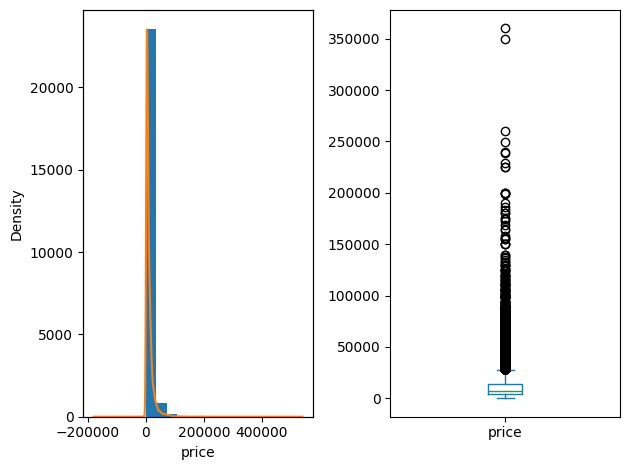

Descriptive statistics


count         24622.0
mean     11310.052392
std      14666.085482
min             104.0
25%            3800.0
50%            6900.0
75%           13500.0
max          360000.0
Name: price, dtype: Float64

Variance: 1.2967301099439885
Skewness: 5.739281624472869
Kurtosis: 64.91036913440722

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, current_col)

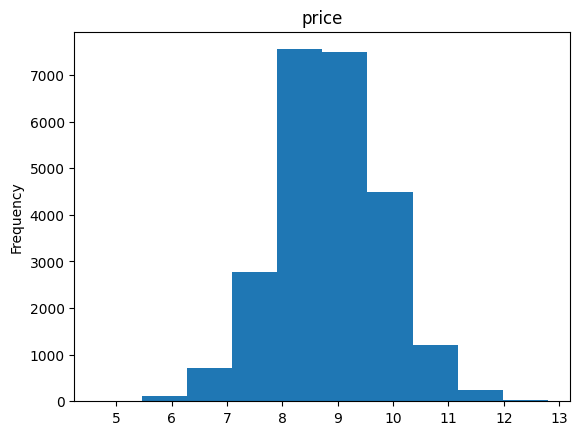

In [ ]:
df_train[current_col].apply(np.log1p).plot(kind="hist", title=current_col);

In [ ]:
current_col = "listing_followers_no"
da_utils.display_feature_name_heading(current_col)

display(df_train[current_col].head())

<h3>'listing_followers_no' feature</h3>

id
22699698     3
23221633     3
22569748    18
22641862    32
23220545     2
Name: listing_followers_no, dtype: string

In [ ]:
if (df_train[current_col] == "").sum() == pd.to_numeric(df_train[current_col]).isna().sum():
    df_train[current_col] = pd.to_numeric(df_train[current_col])
else:
    raise ValueError("There is a listing_followers_no value that is probably incorrectly parsed.")

if (df_test[current_col] == "").sum() == pd.to_numeric(df_test[current_col]).isna().sum():
    df_test[current_col] = pd.to_numeric(df_test[current_col])
else:
    raise ValueError("There is a listing_followers_no value that is probably incorrectly parsed.")

Univariate analysis of 'listing_followers_no' column
Histogram and box plot


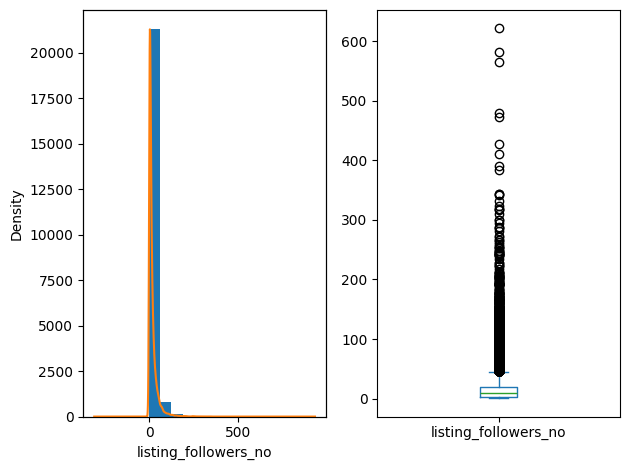

Descriptive statistics


count      22365.0
mean     17.489425
std       27.41364
min            1.0
25%            3.0
50%            9.0
75%           20.0
max          621.0
Name: listing_followers_no, dtype: Float64

Variance: 1.5674408328171134
Skewness: 5.726671953980806
Kurtosis: 61.87304657834173

NA values
Count [n]: 2257
Percentage [%]: 9.166598976525059%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, current_col)

Missing values actually represents zero, so the imputation will be done accordingly.

In [ ]:
df_train.fillna(value={current_col: 0}, inplace=True)
df_test.fillna(value={current_col: 0}, inplace=True)

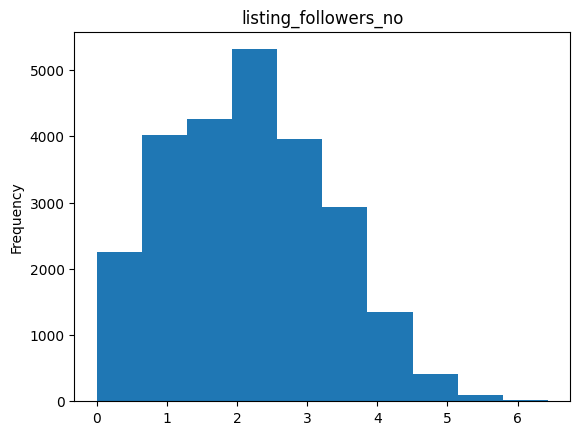

In [ ]:
df_train[current_col].apply(np.log1p).plot(kind="hist", title=current_col);

In [ ]:
features_info["numerical"].append(current_col)

In [ ]:
current_col = "location"
da_utils.display_feature_name_heading(current_col)

display(df_train[current_col].head())

<h3>'location' feature</h3>

id
22699698              Beograd
23221633             Novi Sad
22569748    Sremska Mitrovica
22641862                Futog
23220545         Novi Beograd
Name: location, dtype: string

In [ ]:
da_utils.get_value_counts_freq_with_perc(df_train, column=current_col)

,count,percentage [%]
location,,
Beograd,4066,16.513687
Novi Sad,1808,7.343027
Niš,1045,4.244172
Kragujevac,905,3.675575
Čačak,783,3.180083
...,...,...
Drakčići,1,0.004061
Ledinci,1,0.004061
Deveti Maj,1,0.004061


In [ ]:
features_info["nominal"].append(current_col)

In [ ]:
current_col = "images_no"
da_utils.display_feature_name_heading(current_col)

display(df_train[current_col].head())

<h3>'images_no' feature</h3>

id
22699698    15
23221633    15
22569748    20
22641862    30
23220545     6
Name: images_no, dtype: string

In [ ]:
pd.to_numeric(df_train[current_col]).isna().sum()

0

In [ ]:
df_train[current_col] = pd.to_numeric(df_train[current_col])
df_test[current_col] = pd.to_numeric(df_test[current_col])

Univariate analysis of 'images_no' column
Histogram and box plot


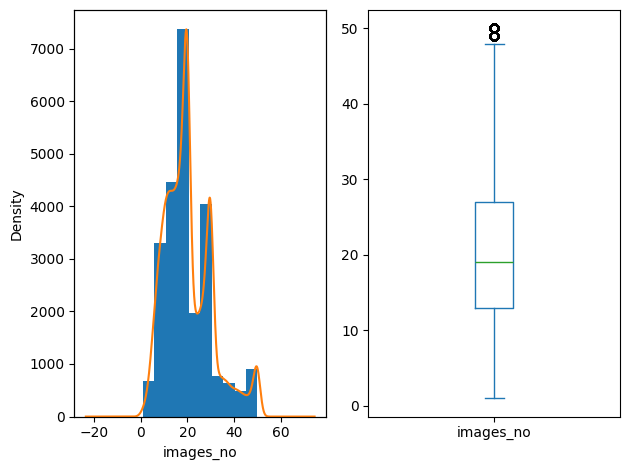

Descriptive statistics


count      24622.0
mean     20.391398
std      10.248639
min            1.0
25%           13.0
50%           19.0
75%           27.0
max           50.0
Name: images_no, dtype: Float64

Variance: 0.5025962116400101
Skewness: 0.8834781503340093
Kurtosis: 0.6518418348517869

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, current_col)

In [ ]:
features_info["numerical"].append(current_col)

In [ ]:
current_col = "safety"
da_utils.display_feature_name_heading(current_col)

display(df_train[current_col].head())

<h3>'safety' feature</h3>

id
22699698    Airbag za vozača,Airbag za suvozača,Bočni airb...
23221633    Airbag za vozača,Airbag za suvozača,Bočni airb...
22569748    Airbag za vozača,Airbag za suvozača,Bočni airb...
22641862    Airbag za vozača,Airbag za suvozača,Bočni airb...
23220545    Airbag za vozača,Airbag za suvozača,Bočni airb...
Name: safety, dtype: string

In [ ]:
df_train_safety_dummies = df_train[current_col].str.get_dummies(sep=",").add_prefix("s_")
df_test_safety_dummies = df_test[current_col].str.get_dummies(sep=",").add_prefix("s_")

safety_columns = df_train_safety_dummies.columns.tolist()

df_train = pd.concat([df_train, df_train_safety_dummies], axis=1)
df_test = pd.concat([df_test, df_test_safety_dummies], axis=1)

del df_train_safety_dummies
del df_test_safety_dummies

del df_train[current_col]
del df_test[current_col]

In [ ]:
for col in safety_columns:
    display(da_utils.get_value_counts_freq_with_perc(df_train, col))

,count,percentage [%]
s_ABS,,
1,22832,92.730079
0,1790,7.269921


,count,percentage [%]
s_ASR,,
1,17833,72.427098
0,6789,27.572902


,count,percentage [%]
s_Airbag za suvozača,,
1,22974,93.306799
0,1648,6.693201


,count,percentage [%]
s_Airbag za vozača,,
1,23130,93.940379
0,1492,6.059621


,count,percentage [%]
s_Alarm,,
0,17866,72.561124
1,6756,27.438876


,count,percentage [%]
s_Asistencija praćenja trake,,
0,20817,84.546341
1,3805,15.453659


,count,percentage [%]
s_Automatsko kočenje,,
0,20709,84.107709
1,3913,15.892291


,count,percentage [%]
s_Blokada motora,,
0,17793,72.264641
1,6829,27.735359


,count,percentage [%]
s_Bočni airbag,,
1,21351,86.715133
0,3271,13.284867


,count,percentage [%]
s_Centralno zaključavanje,,
1,22606,91.8122
0,2016,8.1878


,count,percentage [%]
s_Child lock,,
1,13857,56.278938
0,10765,43.721062


,count,percentage [%]
s_ESP,,
1,18911,76.805296
0,5711,23.194704


,count,percentage [%]
s_Kodiran ključ,,
1,15707,63.792543
0,8915,36.207457


,count,percentage [%]
s_Mehanička zaštita,,
0,23154,94.037852
1,1468,5.962148


,count,percentage [%]
s_OBD zaštita,,
0,19988,81.179433
1,4634,18.820567


,count,percentage [%]
s_Senzor mrtvog ugla,,
0,22407,91.00398
1,2215,8.99602


,count,percentage [%]
s_Ulazak bez ključa,,
0,20496,83.242629
1,4126,16.757371


,count,percentage [%]
s_Vazdušni jastuci za kolena,,
0,19442,78.961904
1,5180,21.038096


In [ ]:
features_info["binary"].extend(safety_columns)

In [ ]:
current_col = "equipment"
da_utils.display_feature_name_heading(current_col)

display(df_train[current_col].head())

<h3>'equipment' feature</h3>

id
22699698    Metalik boja,Branici u boji auta,Servo volan,M...
23221633    Servo volan,Daljinsko zaključavanje,Tonirana s...
22569748    Servo volan,Multifunkcionalni volan,Tempomat,D...
22641862    Metalik boja,Branici u boji auta,Servo volan,M...
23220545    Servo volan,Daljinsko zaključavanje,Putni raču...
Name: equipment, dtype: string

In [ ]:
df_train_equipment_dummies = df_train[current_col].str.get_dummies(sep=",").add_prefix("e_")
df_test_equipment_dummies = df_test[current_col].str.get_dummies(sep=",").add_prefix("e_")

equipment_columns = df_train_equipment_dummies.columns.tolist()

df_train = pd.concat([df_train, df_train_equipment_dummies], axis=1)
df_test = pd.concat([df_test, df_test_equipment_dummies], axis=1)

del df_train_equipment_dummies
del df_test_equipment_dummies

del df_train[current_col]
del df_test[current_col]

In [ ]:
for col in equipment_columns:
    display(da_utils.get_value_counts_freq_with_perc(df_train, col))

,count,percentage [%]
e_360 kamera,,
0,23594,95.824872
1,1028,4.175128


,count,percentage [%]
e_AUX konekcija,,
0,14088,57.217123
1,10534,42.782877


,count,percentage [%]
e_Adaptivna svetla,,
0,19703,80.021932
1,4919,19.978068


,count,percentage [%]
e_Adaptivni tempomat,,
0,20930,85.00528
1,3692,14.99472


,count,percentage [%]
e_Aluminijumske felne,,
1,17477,70.981236
0,7145,29.018764


,count,percentage [%]
e_Ambijentalno osvetljenje,,
0,21105,85.716026
1,3517,14.283974


,count,percentage [%]
e_Android Auto,,
0,21752,88.343758
1,2870,11.656242


,count,percentage [%]
e_Apple CarPlay,,
0,21824,88.636179
1,2798,11.363821


,count,percentage [%]
e_Asistencija za kretanje na uzbrdici,,
0,15478,62.862481
1,9144,37.137519


,count,percentage [%]
e_Automatsko parkiranje,,
0,22820,92.681342
1,1802,7.318658


,count,percentage [%]
e_Automatsko zatamnjivanje retrovizora,,
0,17615,71.541711
1,7007,28.458289


,count,percentage [%]
e_Autonomna vožnja,,
0,23630,95.971083
1,992,4.028917


,count,percentage [%]
e_Bluetooth,,
0,13322,54.106084
1,11300,45.893916


,count,percentage [%]
e_Branici u boji auta,,
1,15970,64.860694
0,8652,35.139306


,count,percentage [%]
e_Brisači prednjih farova,,
0,22326,90.675006
1,2296,9.324994


,count,percentage [%]
e_CD changer,,
0,21519,87.397449
1,3103,12.602551


,count,percentage [%]
e_DPF filter,,
0,14672,59.588985
1,9950,40.411015


,count,percentage [%]
e_DVD/TV,,
0,22235,90.305418
1,2387,9.694582


,count,percentage [%]
e_Daljinsko zaključavanje,,
1,20867,84.749411
0,3755,15.250589


,count,percentage [%]
e_Digitalni radio,,
0,18950,76.963691
1,5672,23.036309


,count,percentage [%]
e_Dnevna svetla,,
1,13063,53.054179
0,11559,46.945821


,count,percentage [%]
e_Držači za čaše,,
1,18933,76.894647
0,5689,23.105353


,count,percentage [%]
e_Ekran na dodir,,
0,18106,73.535862
1,6516,26.464138


,count,percentage [%]
e_Električni podizači,,
1,22447,91.166437
0,2175,8.833563


,count,percentage [%]
e_Električni retrovizori,,
1,20935,85.025587
0,3687,14.974413


,count,percentage [%]
e_Elektro otvaranje prtljažnika,,
0,14269,57.952238
1,10353,42.047762


,count,percentage [%]
e_Elektro podesiva sedišta,,
0,19049,77.36577
1,5573,22.63423


,count,percentage [%]
e_Elektro sklopivi retrovizori,,
0,17506,71.099017
1,7116,28.900983


,count,percentage [%]
e_Elektro zatvaranje prtljažnika,,
0,22377,90.882138
1,2245,9.117862


,count,percentage [%]
e_Elektronska ručna kočnica,,
0,17033,69.177971
1,7589,30.822029


,count,percentage [%]
e_Fabrički ugrađeno dečije sedište,,
0,24528,99.618228
1,94,0.381772


,count,percentage [%]
e_Glasovne komande,,
0,19979,81.14288
1,4643,18.85712


,count,percentage [%]
e_Grejanje sedišta,,
0,18022,73.194704
1,6600,26.805296


,count,percentage [%]
e_Grejanje volana,,
0,23645,96.032004
1,977,3.967996


,count,percentage [%]
e_Grejači retrovizora,,
1,18329,74.441556
0,6293,25.558444


,count,percentage [%]
e_Grejači vetrobranskog stakla,,
0,19761,80.257493
1,4861,19.742507


,count,percentage [%]
e_Hands free,,
0,16860,68.475347
1,7762,31.524653


,count,percentage [%]
e_Hard disk,,
0,22910,93.046869
1,1712,6.953131


,count,percentage [%]
e_Head-up display,,
0,23653,96.064495
1,969,3.935505


,count,percentage [%]
e_ISOFIX sistem,,
1,17753,72.102185
0,6869,27.897815


,count,percentage [%]
e_Indikator niskog pritiska u gumama,,
0,14390,58.443668
1,10232,41.556332


,count,percentage [%]
e_Kamera,,
0,20379,82.767444
1,4243,17.232556


,count,percentage [%]
e_Keramičke kočnice,,
0,24414,99.155227
1,208,0.844773


,count,percentage [%]
e_Kožni volan,,
1,15902,64.584518
0,8720,35.415482


,count,percentage [%]
e_Krovni nosač,,
0,18221,74.002924
1,6401,25.997076


,count,percentage [%]
e_Kuka za vuču,,
0,21932,89.074811
1,2690,10.925189


,count,percentage [%]
e_LED prednja svetla,,
0,16168,65.664853
1,8454,34.335147


,count,percentage [%]
e_LED zadnja svetla,,
0,16320,66.282187
1,8302,33.717813


,count,percentage [%]
e_MP3,,
0,13763,55.897165
1,10859,44.102835


,count,percentage [%]
e_Masažna sedišta,,
0,23991,97.437251
1,631,2.562749


,count,percentage [%]
e_Matrix farovi,,
0,23317,94.699862
1,1305,5.300138


,count,percentage [%]
e_Memorija sedišta,,
0,22923,93.099667
1,1699,6.900333


,count,percentage [%]
e_Metalik boja,,
1,14329,58.195922
0,10293,41.804078


,count,percentage [%]
e_Modovi vožnje,,
0,20072,81.520591
1,4550,18.479409


,count,percentage [%]
e_Multifunkcionalni volan,,
1,16005,65.002843
0,8617,34.997157


,count,percentage [%]
e_Multimedija,,
0,14690,59.662091
1,9932,40.337909


,count,percentage [%]
e_Naslon za ruku,,
1,15891,64.539842
0,8731,35.460158


,count,percentage [%]
e_Navigacija,,
0,15653,63.573227
1,8969,36.426773


,count,percentage [%]
e_Ostava sa hlađenjem,,
0,16632,67.549346
1,7990,32.450654


,count,percentage [%]
e_Otvor za skije,,
0,21285,86.44708
1,3337,13.55292


,count,percentage [%]
e_Paljenje bez ključa,,
0,19155,77.79628
1,5467,22.20372


,count,percentage [%]
e_Panorama krov,,
0,22499,91.37763
1,2123,8.62237


,count,percentage [%]
e_Parking senzori,,
0,13041,52.964828
1,11581,47.035172


,count,percentage [%]
e_Podešavanje volana po visini,,
1,19879,80.73674
0,4743,19.26326


,count,percentage [%]
e_Postolje za bežično punjenje telefona,,
0,23485,95.382179
1,1137,4.617821


,count,percentage [%]
e_Prednja noćna kamera,,
0,24229,98.403866
1,393,1.596134


,count,percentage [%]
e_Privlačenje vrata pri zatvaranju,,
0,24124,97.977419
1,498,2.022581


,count,percentage [%]
e_Putni računar,,
1,19293,78.356754
0,5329,21.643246


,count,percentage [%]
e_Radio CD,,
1,17051,69.251076
0,7571,30.748924


,count,percentage [%]
e_Radio/Kasetofon,,
1,13872,56.339859
0,10750,43.660141


,count,percentage [%]
e_Retrovizor se obara pri rikvercu,,
0,21723,88.225977
1,2899,11.774023


,count,percentage [%]
e_Rezervni točak,,
0,12877,52.298757
1,11745,47.701243


,count,percentage [%]
e_Ručice za menjanje brzina na volanu,,
0,21722,88.221915
1,2900,11.778085


,count,percentage [%]
e_Sedišta podesiva po visini,,
1,17074,69.344489
0,7548,30.655511


,count,percentage [%]
e_Senzori za kišu,,
1,12975,52.696775
0,11647,47.303225


,count,percentage [%]
e_Senzori za svetla,,
1,12414,50.418325
0,12208,49.581675


,count,percentage [%]
e_Servo volan,,
1,23040,93.574852
0,1582,6.425148


,count,percentage [%]
e_Sportska sedišta,,
0,19967,81.094143
1,4655,18.905857


,count,percentage [%]
e_Sportsko vešanje,,
0,22396,90.959305
1,2226,9.040695


,count,percentage [%]
e_Start-stop sistem,,
0,17749,72.085939
1,6873,27.914061


,count,percentage [%]
e_Subwoofer,,
0,22935,93.148404
1,1687,6.851596


,count,percentage [%]
e_Svetla za maglu,,
1,17954,72.918528
0,6668,27.081472


,count,percentage [%]
e_Tempomat,,
1,15349,62.338559
0,9273,37.661441


,count,percentage [%]
e_Tonirana stakla,,
1,19103,77.585087
0,5519,22.414913


,count,percentage [%]
e_Torba za skije,,
0,24249,98.485095
1,373,1.514905


,count,percentage [%]
e_USB,,
0,14350,58.281212
1,10272,41.718788


,count,percentage [%]
e_Upravljanje na sva četiri točka,,
0,23753,96.470636
1,869,3.529364


,count,percentage [%]
e_Utičnica od 12V,,
1,16970,68.922102
0,7652,31.077898


,count,percentage [%]
e_Vazdušno vešanje,,
0,23812,96.710259
1,810,3.289741


,count,percentage [%]
e_Ventilacija sedišta,,
0,24086,97.823085
1,536,2.176915


,count,percentage [%]
e_Virtuelna tabla,,
0,22861,92.84786
1,1761,7.15214


,count,percentage [%]
e_Volan u kombinaciji drvo/koža,,
0,24481,99.427341
1,141,0.572659


,count,percentage [%]
e_Webasto,,
0,23791,96.62497
1,831,3.37503


,count,percentage [%]
e_Xenon svetla,,
0,18884,76.695638
1,5738,23.304362


,count,percentage [%]
e_Zaključavanje diferencijala,,
0,23812,96.710259
1,810,3.289741


,count,percentage [%]
e_Zavesice na zadnjim prozorima,,
0,23612,95.897977
1,1010,4.102023


,count,percentage [%]
e_Šiber,,
0,23051,93.619527
1,1571,6.380473


In [ ]:
to_drop = ["e_Fabrički ugrađeno dečije sedište", "e_Volan u kombinaciji drvo/koža"]
to_add_binary = [col for col in equipment_columns if col not in to_drop]

features_info["binary"].extend(to_add_binary)
features_info["features_to_delete"].extend(to_drop)

del to_drop, to_add_binary

In [ ]:
current_col = "other"
da_utils.display_feature_name_heading(current_col)

display(df_train[current_col].head())

<h3>'other' feature</h3>

id
22699698              Garancija,Rezervni ključ
23221633                        Rezervni ključ
22569748                                      
22641862    Garancija,Garažiran,Rezervni ključ
23220545                                      
Name: other, dtype: string

In [ ]:
df_train_other_dummies = df_train[current_col].str.get_dummies(sep=",").add_prefix("o_")
df_test_other_dummies = df_test[current_col].str.get_dummies(sep=",").add_prefix("o_")

other_columns = df_train_other_dummies.columns.tolist()

df_train = pd.concat([df_train, df_train_other_dummies], axis=1)
df_test = pd.concat([df_test, df_test_other_dummies], axis=1)

del df_train_other_dummies
del df_test_other_dummies

del df_train[current_col]
del df_test[current_col]

In [ ]:
for col in other_columns:
    display(da_utils.get_value_counts_freq_with_perc(df_train, col))

,count,percentage [%]
o_Garancija,,
0,17988,73.056616
1,6634,26.943384


,count,percentage [%]
o_Garažiran,,
0,15006,60.945496
1,9616,39.054504


,count,percentage [%]
o_Kupljen nov u Srbiji,,
0,22221,90.248558
1,2401,9.751442


,count,percentage [%]
o_Oldtimer,,
0,24556,99.731947
1,66,0.268053


,count,percentage [%]
o_Prilagođeno invalidima,,
0,24614,99.967509
1,8,0.032491


,count,percentage [%]
o_Prvi vlasnik,,
0,19896,80.805783
1,4726,19.194217


,count,percentage [%]
o_Restauriran,,
0,24571,99.792868
1,51,0.207132


,count,percentage [%]
o_Rezervni ključ,,
1,12381,50.284299
0,12241,49.715701


,count,percentage [%]
o_Servisna knjiga,,
0,13751,55.848428
1,10871,44.151572


,count,percentage [%]
o_Taxi,,
0,24613,99.963447
1,9,0.036553


,count,percentage [%]
o_Test vozilo,,
0,24551,99.71164
1,71,0.28836


,count,percentage [%]
o_Tuning,,
0,24491,99.467955
1,131,0.532045


,count,percentage [%]
o_Vozilo auto škole,,
0,24619,99.987816
1,3,0.012184


In [ ]:
features_info["binary"].extend(["o_Garancija", "o_Garažiran", "o_Kupljen nov u Srbiji", "o_Prvi vlasnik", "o_Rezervni ključ", "o_Servisna knjiga"])
features_info["features_to_delete"].extend(["o_Oldtimer", "o_Prilagođeno invalidima", "o_Taxi", "o_Test vozilo", "o_Vozilo auto škole"])
features_info["other"].extend(["o_Tuning", "o_Restauriran"])

In [ ]:
features_info["other"].append('description')

### "GeneralInformation" features

In [ ]:
gi_columns = ['gi_condition', 'gi_brand', 'gi_model', 'gi_production_year', 'gi_kilometerage',
       'gi_body_type', 'gi_fuel_type', 'gi_engine_capacity', 'gi_engine_power',
       'gi_trade_in', 'gi_certified', 'gi_battery_capacity']

print("Descriptives for GeneralInformation columns")
display(df_train[gi_columns].describe())
print()
print("Value counts for GeneralInformation columns")
for col in gi_columns:
    display(da_utils.get_value_counts_freq_with_perc(df_train, col))
del gi_columns

Descriptives for GeneralInformation columns


,gi_condition,gi_brand,gi_model,gi_production_year,gi_kilometerage,gi_body_type,gi_fuel_type,gi_engine_capacity,gi_engine_power,gi_trade_in,gi_certified,gi_battery_capacity
count,24622,24622,24622,24622,24622,24622,24622,24482,24622,24622,1381,140
unique,2,72,901,61,9486,9,10,572,292,6,105,71
top,Polovno vozilo,Volkswagen,A4,2008.,250.000 km,Hečbek,Dizel,1968 cm3,110/150 (kW/KS),NE,Nije atestiran,17 kWh
freq,24102,3852,691,1589,303,8292,16576,2861,2012,18089,137,11



Value counts for GeneralInformation columns


,count,percentage [%]
gi_condition,,
Polovno vozilo,24102,97.888068
Novo vozilo,520,2.111932


,count,percentage [%]
gi_brand,,
Volkswagen,3852,15.644546
Audi,2574,10.454065
BMW,2222,9.02445
Opel,1914,7.773536
Renault,1595,6.477947
...,...,...
Wartburg,1,0.004061
Cadillac,1,0.004061
Acura,1,0.004061


,count,percentage [%]
gi_model,,
A4,691,2.806433
A3,519,2.107871
Octavia,511,2.07538
A6,499,2.026643
Golf 7,463,1.880432
...,...,...
CLK 230,1,0.004061
GLA 250,1,0.004061
EV6,1,0.004061


,count,percentage [%]
gi_production_year,,
2008.,1589,6.453578
2011.,1564,6.352043
2010.,1504,6.108358
2007.,1469,5.966209
2009.,1463,5.941841
...,...,...
1957.,1,0.004061
1953.,1,0.004061
1968.,1,0.004061


,count,percentage [%]
gi_kilometerage,,
250.000 km,303,1.230607
0 km,264,1.072212
230.000 km,262,1.064089
220.000 km,257,1.043782
200.000 km,247,1.003168
...,...,...
138.054 km,1,0.004061
215.402 km,1,0.004061
105.888 km,1,0.004061


,count,percentage [%]
gi_body_type,,
Hečbek,8292,33.677199
Džip/SUV,5092,20.680692
Limuzina,4513,18.329137
Karavan,3702,15.035334
Monovolumen (MiniVan),1964,7.976606
Kupe,636,2.583056
Kabriolet/Roadster,249,1.011291
Pickup,173,0.702624
,1,0.004061


,count,percentage [%]
gi_fuel_type,,
Dizel,16576,67.321907
Benzin,6223,25.274145
Benzin + Gas (TNG),924,3.752741
Benzin + Metan (CNG),456,1.852002
Hibridni pogon,265,1.076273
Električni pogon,140,0.568597
Hibridni pogon (Benzin),23,0.093412
Hibridni pogon (Dizel),11,0.044675
Plug-in hibrid,3,0.012184


,count,percentage [%]
gi_engine_capacity,,
1968 cm3,2861,11.61969
1598 cm3,2216,9.000081
1995 cm3,1674,6.798798
1560 cm3,1165,4.731541
1461 cm3,980,3.98018
...,...,...
1098 cm3,1,0.004061
963 cm3,1,0.004061
1479 cm3,1,0.004061


,count,percentage [%]
gi_engine_power,,
110/150 (kW/KS),2012,8.171554
103/140 (kW/KS),1553,6.307367
85/116 (kW/KS),1309,5.316384
77/105 (kW/KS),1165,4.731541
81/110 (kW/KS),1071,4.349768
...,...,...
61/82 (kW/KS),1,0.004061
181/246 (kW/KS),1,0.004061
382/519 (kW/KS),1,0.004061


,count,percentage [%]
gi_trade_in,,
NE,18089,73.466818
DA,2965,12.042076
DA (za jeftinije),2249,9.134108
DA (za skuplje),791,3.212574
DA (u istoj ceni),365,1.482414
DA (staro za novo),163,0.66201


,count,percentage [%]
gi_certified,,
<NA>,23241,94.391195
Nije atestiran,137,0.556413
do: 07.2027,44,0.178702
do: 10.2027,40,0.162456
do: 12.2027,39,0.158395
...,...,...
do: 08.2031,1,0.004061
do: 09.2030,1,0.004061
do: 02.2023,1,0.004061


,count,percentage [%]
gi_battery_capacity,,
<NA>,24482,99.431403
17 kWh,11,0.044675
75 kWh,7,0.02843
77.4 kWh,5,0.020307
42 kWh,5,0.020307
...,...,...
74.3 kWh,1,0.004061
17.6 kWh,1,0.004061
71.4 kWh,1,0.004061


Only used cars will be left in the dataset, so all new cars are going to be deleted.

In [ ]:
new_cars_cond_train = df_train.gi_condition == "Novo vozilo"
new_cars_cond_test = df_test.gi_condition == "Novo vozilo"

df_train = df_train.loc[~new_cars_cond_train, :]
print(f"Rows deleted from df_train: {new_cars_cond_train.sum()}")
df_test = df_test.loc[~new_cars_cond_test, :]

features_info["features_to_delete"].append("gi_condition")

Rows deleted from df_train: 520


In [ ]:
pd.options.display.max_rows = None
display(df_train.gi_brand.value_counts())
pd.reset_option('display.max_rows', 0)

gi_brand
Volkswagen       3839
Audi             2569
BMW              2206
Opel             1894
Renault          1569
Peugeot          1566
Mercedes Benz    1437
Fiat             1192
Škoda            1124
Citroen          1076
Ford             1069
Nissan            471
Toyota            416
Seat              360
Alfa Romeo        301
Kia               301
Hyundai           279
Volvo             275
Mazda             236
Land Rover        198
Suzuki            191
MINI              161
Mitsubishi        139
Dacia             133
Honda             132
Smart             110
Porsche           108
Chevrolet         101
Jeep               96
Lancia             89
Zastava            86
Subaru             54
Jaguar             53
Lada               30
Saab               27
Daewoo             26
Dodge              24
Daihatsu           22
Lexus              18
Chrysler           16
SsangYong          13
Tesla              13
Rover              11
DS                  9
Infiniti            8
M

In [ ]:
pd.options.display.max_rows = None
display(df_train.gi_model.value_counts().head(60))
pd.reset_option('display.max_rows', 0)

gi_model
A4              691
A3              519
Octavia         502
A6              499
Golf 7          463
Polo            392
Megane          391
320             391
Clio            368
Golf 5          362
308             358
Golf 6          350
520             336
Tiguan          316
Passat B6       292
Focus           278
C3              245
Insignia        243
Touran          238
Passat B8       233
Corsa D         231
Qashqai         230
Fiesta          225
Astra J         221
Astra H         219
Superb          201
Scenic          192
Q5              191
X3              189
3008            183
Passat B7       182
Zafira          178
318             174
X1              171
207             167
Fabia           166
C5              162
Meriva          162
Kuga            151
Grande Punto    151
E 220           146
A5              146
Sportage        145
Panda           144
500             143
307             138
208             136
Ibiza           136
Punto           136
C4         

In [ ]:
df_train.gi_production_year = pd.to_numeric(df_train.gi_production_year.str.rstrip("."))
df_test.gi_production_year = pd.to_numeric(df_test.gi_production_year.str.rstrip("."))

Univariate analysis of 'gi_production_year' column
Histogram and box plot


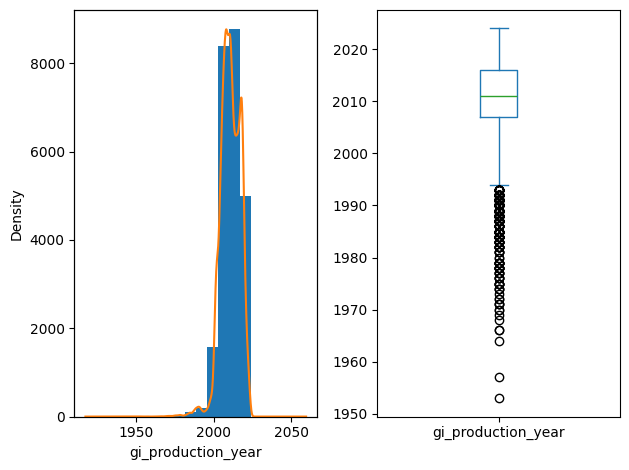

Descriptive statistics


count        24102.0
mean     2010.673554
std         6.282109
min           1953.0
25%           2007.0
50%           2011.0
75%           2016.0
max           2024.0
Name: gi_production_year, dtype: Float64

Variance: 0.003124380584533498
Skewness: -0.8432235946074103
Kurtosis: 3.0047745482984887

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, "gi_production_year")

In [ ]:
df_train.gi_kilometerage = pd.to_numeric(df_train.gi_kilometerage.str.rstrip("km").str.replace(".", ""))
df_test.gi_kilometerage = pd.to_numeric(df_test.gi_kilometerage.str.rstrip("km").str.replace(".", ""))

Univariate analysis of 'gi_kilometerage' column
Histogram and box plot


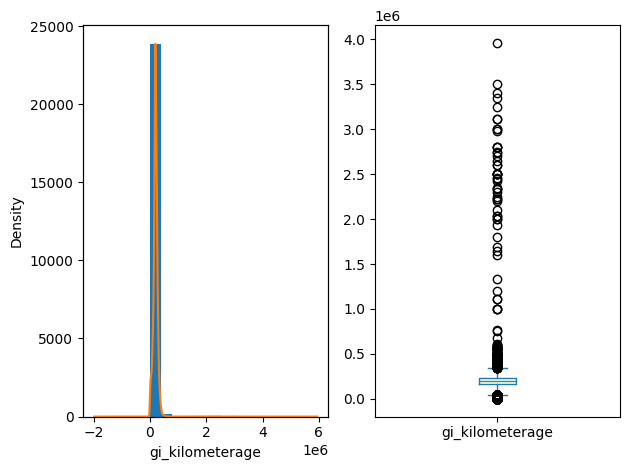

Descriptive statistics


count          24102.0
mean     199350.317401
std      126926.753389
min                0.0
25%           160000.0
50%           195000.0
75%           235000.0
max          3960000.0
Name: gi_kilometerage, dtype: Float64

Variance: 0.6367020381210946
Skewness: 13.403709997261064
Kurtosis: 277.9331034783259

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, "gi_kilometerage")

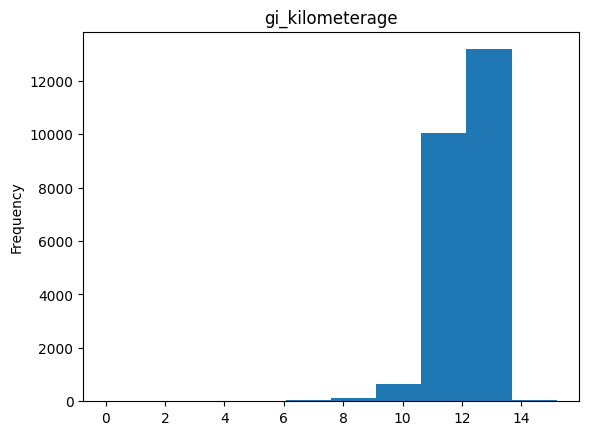

In [ ]:
df_train.gi_kilometerage.apply(np.log1p).plot(kind="hist", title="gi_kilometerage");

Empty value in gi_body_type will be replaced with NaN, in order to later handle it probably by imputing the mode (keeping it simple for now).

In [ ]:
df_train.loc[df_train.gi_body_type == "", "gi_body_type"] = np.nan
df_test.loc[df_test.gi_body_type == "", "gi_body_type"] = np.nan

In [ ]:
df_train.gi_fuel_type = df_train.gi_fuel_type.replace({
    "Hibridni pogon (Benzin)": "Hibridni pogon",
    "Hibridni pogon (Dizel)": "Hibridni pogon",
    "Plug-in hibrid": "Hibridni pogon",
    "Metan CNG": "Benzin + Metan (CNG)"
})
df_test.gi_fuel_type = df_test.gi_fuel_type.replace({
    "Hibridni pogon (Benzin)": "Hibridni pogon",
    "Hibridni pogon (Dizel)": "Hibridni pogon",
    "Plug-in hibrid": "Hibridni pogon",
    "Metan CNG": "Benzin + Metan (CNG)"
})


In [ ]:
df_train.gi_engine_capacity = pd.to_numeric(df_train.gi_engine_capacity.str.rstrip("cm3"), errors="raise")
df_test.gi_engine_capacity = pd.to_numeric(df_test.gi_engine_capacity.str.rstrip("cm3"), errors="raise")

Univariate analysis of 'gi_engine_capacity' column
Histogram and box plot


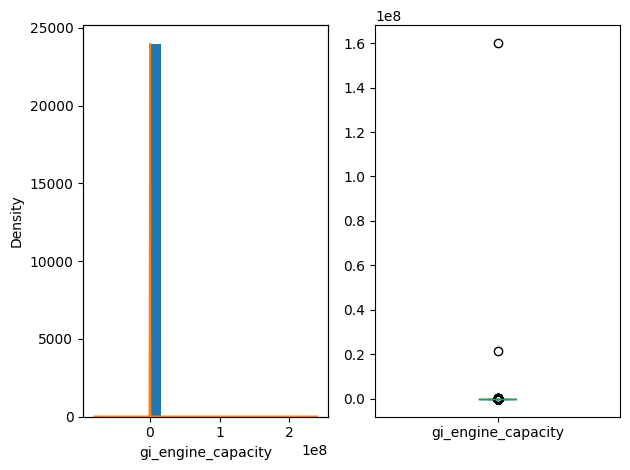

Descriptive statistics


count           23982.0
mean        9422.347636
std      1042771.655666
min               105.0
25%              1461.0
50%              1796.0
75%              1991.0
max         160051414.0
Name: gi_engine_capacity, dtype: Float64

Variance: 110.67004699674848
Skewness: 151.1205840178935
Kurtosis: 23142.70690684023

NA values
Count [n]: 120
Percentage [%]: 0.49788399302962405%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, "gi_engine_capacity")

In [ ]:
df_train.loc[df_train.gi_engine_capacity > 0.2*1e8]

,name,short_url,price,listing_followers_no,location,images_no,description,gi_condition,gi_brand,gi_model,...,o_Oldtimer,o_Prilagođeno invalidima,o_Prvi vlasnik,o_Restauriran,o_Rezervni ključ,o_Servisna knjiga,o_Taxi,o_Test vozilo,o_Tuning,o_Vozilo auto škole
id,,,,,,,,,,,,,,,,,,,,,
22503872,Mercedes Benz E 200 CDi Classic,https://www.polovniautomobili.com/auto-oglasi/...,4500,6.0,Čačak,20,Uslužna prodaja- Vozilo se nalazi kod nas Polo...,Polovno vozilo,Mercedes Benz,E 200,...,0,0,0,0,1,0,0,0,0,0
23210877,Opel Insignia EXCLUSIVE,https://www.polovniautomobili.com/auto-oglasi/...,15200,4.0,Leštane,30,Opel Insignija 1.6D 136 KS 6 brz. Auto je u na...,Polovno vozilo,Opel,Insignia,...,0,0,0,0,1,1,0,0,0,0


In [ ]:
df_train.gi_engine_power = pd.to_numeric(df_train.gi_engine_power.str.split("/", n=1).str.get(0))
df_test.gi_engine_power = pd.to_numeric(df_test.gi_engine_power.str.split("/", n=1).str.get(0))

Univariate analysis of 'gi_engine_power' column
Histogram and box plot


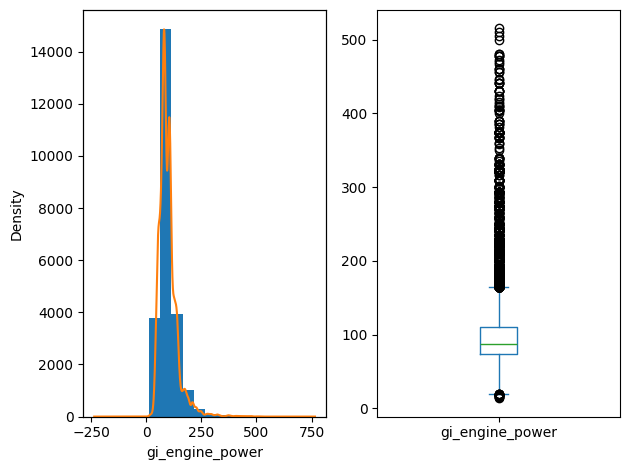

Descriptive statistics


count    24102.000000
mean        98.400299
std         42.999173
min         14.000000
25%         74.000000
50%         88.000000
75%        110.000000
max        515.000000
Name: gi_engine_power, dtype: float64

Variance: 0.4369821339817139
Skewness: 2.5646161507981753
Kurtosis: 12.601608068503792

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, "gi_engine_power")

In [ ]:
df_train.gi_battery_capacity = pd.to_numeric(df_train.gi_battery_capacity.str.rstrip("kWh"))
df_test.gi_battery_capacity = pd.to_numeric(df_test.gi_battery_capacity.str.rstrip("kWh"))

Univariate analysis of 'gi_battery_capacity' column
Histogram and box plot


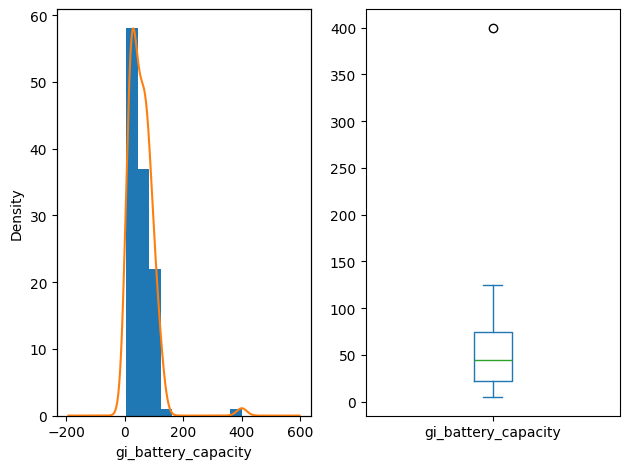

Descriptive statistics


count        119.0
mean     55.712269
std      44.815195
min            5.0
25%           22.0
50%           45.0
75%           75.0
max          400.0
Name: gi_battery_capacity, dtype: Float64

Variance: 0.80440441485068
Skewness: 3.9116408972793004
Kurtosis: 27.26953297745415

NA values
Count [n]: 23983
Percentage [%]: 99.50626504024562%


In [ ]:
da_utils.show_hist_box_numerical_col(df_train, "gi_battery_capacity")

In [ ]:
features_info["nominal"].extend(["gi_brand", "gi_brand", "gi_body_type", "gi_fuel_type", "gi_trade_in"])
features_info["numerical"].extend(["gi_kilometerage", "gi_production_year", "gi_engine_capacity", "gi_engine_power",])
features_info["other"].extend(["gi_model", "gi_battery_capacity", "gi_certified", "gi_kilometerage"])

### "AdditionalInformation" features

In [ ]:
ai_columns = [col for col in df_train.columns if "ai_" in col]

print("Descriptives for AdditionalInformation columns")
display(df_train[ai_columns].describe())
print()
print("Value counts for AdditionalInformation columns")
for col in ai_columns:
    display(da_utils.get_value_counts_freq_with_perc(df_train, col))
del ai_columns

Descriptives for AdditionalInformation columns


,ai_floating_flywheel,ai_engine_emission_class,ai_propulsion,ai_gearbox_type,ai_doors_no,ai_seats_no,ai_steering_wheel_side,ai_air_conditioning,ai_color,ai_interior_material,...,ai_import_country,ai_sales_method,ai_credit,ai_deposit,ai_installment_no,ai_installment_amount,ai_interest_free_credit,ai_leasing,ai_cash_payment,ai_range_on_full_battery_km
count,7689,24096,24102,24101,24101,24102,24102,24102,24102,20808,...,6089,2451,1457,388,491,468,151,626,231,97
unique,2,6,4,6,2,8,2,3,19,5,...,23,2,1,181,21,242,1,1,138,49
top,Sa plivajućim zamajcem,Euro 4,Prednji,Manuelni 5 brzina,4/5 vrata,5 sedišta,Levi volan,Automatska klima,Siva,Štof,...,Švajcarska,Komisiona,DA,30 €,84,115 €,DA,DA,5000 €,300
freq,4957,7188,17490,8491,21613,21599,23991,16345,7749,12997,...,1632,2228,1457,26,271,17,151,626,9,9



Value counts for AdditionalInformation columns


,count,percentage [%]
ai_floating_flywheel,,
<NA>,16413,68.098083
Sa plivajućim zamajcem,4957,20.566758
Bez plivajućeg zamajca,2732,11.335159


,count,percentage [%]
ai_engine_emission_class,,
Euro 4,7188,29.823251
Euro 6,7148,29.65729
Euro 5,6685,27.736287
Euro 3,2549,10.575886
Euro 2,312,1.294498
Euro 1,214,0.887893
<NA>,6,0.024894


,count,percentage [%]
ai_propulsion,,
Prednji,17490,72.566592
4x4,4003,16.60858
Zadnji,2115,8.775205
4x4 reduktor,494,2.049622


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,8491,35.229442
Manuelni 6 brzina,8195,34.001328
Automatski / poluautomatski,7283,30.217409
Manuelni 4 brzine,119,0.493735
Automatski,12,0.049788
Poluautomatski,1,0.004149
<NA>,1,0.004149


,count,percentage [%]
ai_doors_no,,
4/5 vrata,21613,89.673056
2/3 vrata,2488,10.322795
<NA>,1,0.004149


,count,percentage [%]
ai_seats_no,,
5 sedišta,21599,89.61497
4 sedišta,1435,5.953863
7 sedišta,734,3.04539
2 sedišta,268,1.111941
6 sedišta,39,0.161812
3 sedišta,12,0.049788
8 sedišta,8,0.033192
9 sedišta,7,0.029043


,count,percentage [%]
ai_steering_wheel_side,,
Levi volan,23991,99.539457
Desni volan,111,0.460543


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,16345,67.815949
Manuelna klima,6966,28.902166
Nema klimu,791,3.281885


,count,percentage [%]
ai_color,,
Siva,7749,32.150859
Crna,6294,26.114015
Bela,3511,14.567256
Plava,2231,9.256493
Crvena,1090,4.522446
Srebrna,593,2.460377
Teget,571,2.369098
Braon,468,1.941748
Zelena,403,1.67206


,count,percentage [%]
ai_interior_material,,
Štof,12997,53.924985
Prirodna koža,4165,17.280724
<NA>,3294,13.666916
Kombinovana koža,2899,12.028047
Drugi,383,1.58908
Velur,364,1.510248


,count,percentage [%]
ai_interior_color,,
Crna,12283,50.962576
Siva,4655,19.31375
<NA>,4191,17.388598
Druga,1338,5.551407
Bež,1116,4.630321
Smeđa,519,2.153348


,count,percentage [%]
ai_registered_until,,
Nije registrovan,10402,43.158244
06.2024.,1209,5.016181
07.2024.,1186,4.920753
05.2024.,1149,4.767239
04.2024.,1129,4.684259
12.2024.,1116,4.630321
08.2024.,1103,4.576384
11.2024.,1074,4.456062
10.2024.,1073,4.451913


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,14720,61.07377
Na ime kupca,9225,38.274832
Strane tablice,156,0.647249
<NA>,1,0.004149


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,10307,42.764086
<NA>,9398,38.992615
Ne vodi se na prodavca,4397,18.243299


,count,percentage [%]
ai_damage,,
Nije oštećen,23812,98.79678
Oštećen - u voznom stanju,175,0.726081
Oštećen - nije u voznom stanju,112,0.464692
<NA>,3,0.012447


,count,percentage [%]
ai_import_country,,
<NA>,18013,74.736536
Švajcarska,1632,6.771222
Italija,1097,4.55149
Francuska,1004,4.165629
Nemačka,859,3.56402
Holandija,548,2.27367
Belgija,279,1.15758
Norveška,222,0.921085
Austrija,164,0.680441


,count,percentage [%]
ai_sales_method,,
<NA>,21651,89.830719
Komisiona,2228,9.244046
Konsignaciona,223,0.925234


,count,percentage [%]
ai_credit,,
<NA>,22645,93.954859
DA,1457,6.045141


,count,percentage [%]
ai_deposit,,
<NA>,23714,98.390175
30 €,26,0.107875
6000 €,16,0.066385
3000 €,14,0.058086
3900 €,9,0.037341
...,...,...
6390 €,1,0.004149
5849 €,1,0.004149
2385 €,1,0.004149


,count,percentage [%]
ai_installment_no,,
<NA>,23611,97.962825
84,271,1.124388
60,104,0.431499
70,36,0.149365
71,19,0.078832
48,13,0.053937
36,13,0.053937
24,8,0.033192
1,5,0.020745


,count,percentage [%]
ai_installment_amount,,
<NA>,23634,98.058252
115 €,17,0.070534
140 €,9,0.037341
150 €,9,0.037341
94 €,8,0.033192
...,...,...
183 €,1,0.004149
96 €,1,0.004149
236 €,1,0.004149


,count,percentage [%]
ai_interest_free_credit,,
<NA>,23951,99.373496
DA,151,0.626504


,count,percentage [%]
ai_leasing,,
<NA>,23476,97.402705
DA,626,2.597295


,count,percentage [%]
ai_cash_payment,,
<NA>,23871,99.041573
5000 €,9,0.037341
3000 €,7,0.029043
6000 €,7,0.029043
4800 €,6,0.024894
...,...,...
1245 €,1,0.004149
14000 €,1,0.004149
6700 €,1,0.004149


,count,percentage [%]
ai_range_on_full_battery_km,,
<NA>,24005,99.597544
300,9,0.037341
140,6,0.024894
160,5,0.020745
150,5,0.020745
500,4,0.016596
120,4,0.016596
450,3,0.012447
130,3,0.012447


In [ ]:
df_train.ai_engine_emission_class = df_train.ai_engine_emission_class.str.strip("Euro")

df_train.replace(
    {
        "ai_gearbox_type": {
            "Automatski": "Automatski / poluautomatski",
            "Poluautomatski": "Automatski / poluautomatski",
        }
    },
    inplace=True,
)

# df_train.fillna({"ai_doors_no": df_train.ai_doors_no.mode()[0]}, inplace=True)

df_train.ai_doors_no = pd.to_numeric(df_train.ai_doors_no.replace({"4/5 vrata": "1", "2/3 vrata": "0"}))

df_train.ai_seats_no = pd.to_numeric(df_train.ai_seats_no.str.strip("sedišta"))

df_train = df_train.loc[df_train.ai_steering_wheel_side != "Desni volan", :]
del df_train["ai_steering_wheel_side"]

df_train.replace(
    {
        "ai_damage": {
            "Nije oštećen": "0",
            "Oštećen - u voznom stanju": "1",
            "Oštećen - nije u voznom stanju": "2",
        }
    },
    inplace=True,
)

features_info["binary"].extend(["ai_doors_no"])
features_info["ordinal"].extend(["ai_engine_emission_class", "ai_damage"])
features_info["nominal"].extend(
    [
        "ai_floating_flywheel",
        "ai_gearbox_type",
        "ai_air_conditioning",
        "ai_color",
        "ai_interior_material",
        "ai_interior_color",
        "ai_propulsion",
        "ai_vehicle_origin",
        "ai_ownership",
    ]
)
features_info["numerical"].extend(["ai_seats_no"])
features_info["other"].extend(
    [
        "ai_registered_until",
        "ai_import_country",
        "ai_sales_method",
        "ai_credit",
        "ai_deposit",
        "ai_installment_no",
        "ai_installment_amount",
        "ai_interest_free_credit",
        "ai_leasing",
        "ai_cash_payment",
        "ai_range_on_full_battery_km",
    ]
)

In [ ]:
df[features_info["numerical"]] = pd.to_numeric(df[features_info["numerical"]], downcast="unsigned")
df = downcast_nonnumerical_dtypes(df, features_info["binary"], features_info["ordinal"], features_info["nominal"])